In [64]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [65]:
#plot settings
plt.rcParams['figure.figsize'] = 14, 6

In [66]:
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))])

In [67]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)
    
test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/train\cifar-10-python.tar.gz to ./CIFAR10/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/test\cifar-10-python.tar.gz to ./CIFAR10/test


In [129]:
batch_size=4
#change num workers, and batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size*2,shuffle=True, num_workers=4)

(-0.5, 132.5, 33.5, -0.5)

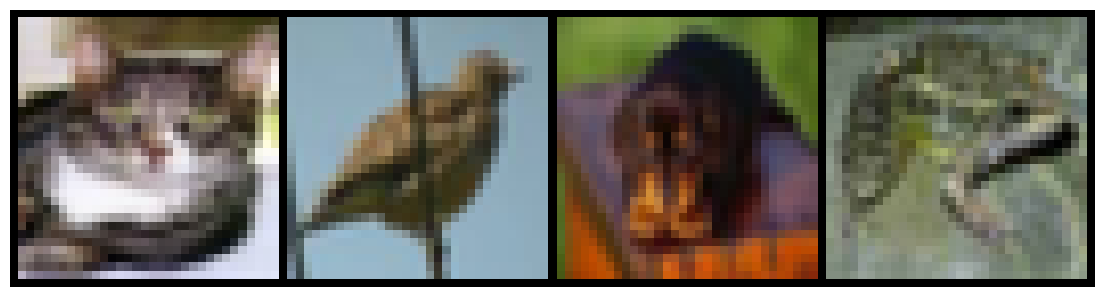

In [130]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [131]:
classList = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data 
    #print (x,y)
    classList.extend(y.tolist())
  
unique, counts = np.unique(classList, return_counts=True)
names = list(test_dataset.class_to_idx.keys())

In [132]:
class convNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model=torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(64*4*4, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
            
        )
        
    def forward(self, x):
        return self.model(x)

In [133]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = convNet().to(device)

#hyper parameters
num_epochs = 20
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
#Training
trainListL = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    train_loss = 0
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
          
        #Extracting images and target labels and sending it to device
        images = images.to(device)
        labels = labels.to(device)
        #Calculating the model output and the cross entropy loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        
    trainListL.append(train_loss/len(train_loader))
    print(f"Training loss = {trainListL[-1]}")   
      
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), trainListL)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Epoch 1/20: Epoch [1/20], Step [2000/12500], Loss: 2.2989
Epoch [1/20], Step [4000/12500], Loss: 2.2891
Epoch [1/20], Step [6000/12500], Loss: 2.2741
Epoch [1/20], Step [8000/12500], Loss: 2.3050
Epoch [1/20], Step [10000/12500], Loss: 3.0324
Epoch [1/20], Step [12000/12500], Loss: 1.6225
Training loss = 2.2087420839595793
Epoch 2/20: Epoch [2/20], Step [2000/12500], Loss: 2.6486
Epoch [2/20], Step [4000/12500], Loss: 2.7700
Epoch [2/20], Step [6000/12500], Loss: 2.0865
Epoch [2/20], Step [8000/12500], Loss: 1.1797
Epoch [2/20], Step [10000/12500], Loss: 1.3756
Epoch [2/20], Step [12000/12500], Loss: 1.4900
Training loss = 1.7390602293157578
Epoch 3/20: Epoch [3/20], Step [2000/12500], Loss: 1.3622
Epoch [3/20], Step [4000/12500], Loss: 1.8413
Epoch [3/20], Step [6000/12500], Loss: 1.2027
Epoch [3/20], Step [8000/12500], Loss: 1.0796
Epoch [3/20], Step [10000/12500], Loss: 0.9963
Epoch [3/20], Step [12000/12500], Loss: 1.5135
Training loss = 1.481356571509838
Epoch 4/20: Epoch [4/20], 

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {names[i]}: {acc} %')

In [2]:
image_number = 6
true_name = [names[labels[idx]] for idx in range(image_number)] 
pred_name = [names[predicted[idx]] for idx in range(image_number)]

#Plots and labels the classes with predicted from training to their respective photo
title = f"Actual labels: {true_name}, Predicted labels: {pred_name}"
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:image_number].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")

NameError: name 'names' is not defined